# Ingest data

In [1]:
import pandas as pd

# Load dataset
raw_data = pd.read_csv('./data/all_metars.csv',low_memory=False)
dataset = raw_data.copy()
print('\nColumns:',[x for x in dataset.columns])
print('\nDataset size:',dataset.shape)


Columns: ['Station_ID', 'Timestamp', 'Longitude', 'Latitude', 'Temperature_F', 'Dew_point_F', 'Relative_humidity', 'Wind_direction_deg', 'Wind_speed_kts', 'One_hour_precip', 'Pressure_altimeter', 'Sea_level_pressure', 'Visibility_mi', 'Wind_gust_kts', 'Sky_cover_L1', 'Sky_cover_L2', 'Sky_cover_L3', 'Sky_cover_L4', 'Sky_alt_L1_ft', 'Sky_alt_L2_ft', 'Sky_alt_L3_ft', 'Sky_alt_L4_ft', 'Weather_codes', 'ice_accretion_1hr', 'ice_accretion_3hr', 'ice_accretion_6hr', 'peak_wind_gust', 'peak_wind_drct', 'peak_wind_time', 'Apparent_temp_F', 'METAR', 'Snow_depth']

Dataset size: (6349496, 32)


## Convert date/time information
- Convert `Timestamp` strings to usable datetime objects

In [2]:
import numpy as np

from datetime import datetime

# Remove known outliers
fix_dat = dataset.drop(dataset[dataset.Timestamp == "2018"].index)
fix_dat = fix_dat.dropna(subset = ['Timestamp','METAR'])

# Add hour information
dt_info = [datetime.strptime(str(x),'%Y-%m-%d %H:%M') for x in fix_dat.Timestamp]

# Combine YEAR, MONTH, and DAY into a single column
fix_dat['DoY'] = [datetime(y,m,d).timetuple().tm_yday for y,m,d in zip([x.year for x in dt_info],
                                                                       [x.month for x in dt_info],
                                                                       [x.day for x in dt_info])]
fix_dat['Hour'] = [x.hour for x in dt_info]

### Extract weather data

Many of the weather code column values are `NaN` despite having a useful METAR value. We'll use the METAR value to extract this information.

In [3]:
# Weather conditions and descriptors
wx_cnd = ['BR', 'CLR', 'DU', 'DZ', 'FG', 'FU', 'GR', 'GS', 'HZ', 'PL', 'PO', 'RA', 'SA', 'SG', 'SN', 'TS', 'UP']
wx_dsc = ['BC', 'BL', 'DR', 'FC', 'FZ', 'MI', 'N', 'PR', 'SH', 'SQ', 'VC']

wx_obs = []

def extract_wx(metar):
    # Filter out airport due to strings
    spc_idx = metar.find(' ')+1
    # Split METAR into list
    sh_met = metar[spc_idx:].split(' ')
    # Find substrings in list of metar elements
    aaa = next((s for s in sh_met if any(xs in s for xs in wx_cnd)), None)
    # Identify non-existent conditions
    if (aaa==None) or (aaa == 'CLR'): condition = 'Clear'
    else: condition = aaa
    return condition
    
metar_obs = [extract_wx(x) for x in fix_dat['METAR']]

In [4]:
# Replace clear labels
metar_clear = [('Clear' if ('CLR' in s) else s) for s in metar_obs]
# Replace fog-like phenomena
foglike = ['FG','BR','HZ']
metar_fog = [('Fog' if any(ext in s for ext in foglike) else s) for s in metar_clear]
# Replace rain-like phenomena
rainlike = ['DZ','RA','TS']
metar_rain = [('Rain' if any(ext in s for ext in rainlike) else s) for s in metar_fog]
# Replace snow-like phenomena
snowlike = ['GR','GS','PL','SG','SN']
metar_snow = [('Snow' if any(ext in s for ext in snowlike) else s) for s in metar_rain]
# Other
dustlike = ['DU','FU','PO','SA','UP']
metar_othr = [('Other' if any(ext in s for ext in dustlike) else s) for s in metar_snow]

[print(x+':',metar_othr.count(x)) for x in ['Fog','Rain','Snow','Clear','Other']]
print('Unique weather conditions:',[x for x in set(metar_othr)])

# Add weather condition column onto existing dataframe
repl_wx = fix_dat.copy()
repl_wx['Condition'] = metar_othr

Fog: 392025
Rain: 637826
Snow: 279883
Clear: 5023260
Other: 16479
Unique weather conditions: ['Fog', 'Rain', 'Snow', 'Other', 'Clear']


### Remove redundant / unhelpful columns

We're removing a large number of columns, but there are many columns in the dataset to begin with. The columns we're removing, and their reason for removal, are as follows.
- `Station_ID`: The actual ID name has no effect on fog
- `Timestamp`: Redundant, based on extracted day-of-year and hour info.
- `Wind_direction_deg`: Fog is based on the presence of wind, not its direction
- `Wind_gust_kts`: We only need wind magnitude (`Wind_speed_kts`)
- `Sky_cover_*`: We're keeping levels low to the ground (L1,L2)
- `Sky_alt_*`: See above
- `ice_accretion_*`: If this has an effect, we're only keeping recent accretions (e.g. 1 hr)
- `peak_wind_*`: Including `drct`, `gust`,and `time` parameters, since these are redundant for our temporal resolution.
- `METAR` is also redundant, now that we've interpreted each weather catagory based on the METAR value.
- `Apparent_temp_F`: Our analysis depends on the outside temperature, not the temperature humans perceive outside to be.

Right now, my hypothesis is that `Apparent_temp_F` and `Snow_depth` won't matter much, but we'll keep them in just in case.

In [5]:
simp_df = repl_wx.drop(columns=['Station_ID', 'Timestamp', 'Wind_direction_deg', 'Wind_gust_kts',
                                'Sky_cover_L3', 'Sky_cover_L4', 'Sky_alt_L3_ft', 'Sky_alt_L4_ft',
                                'Weather_codes','peak_wind_gust', 'peak_wind_drct', 'peak_wind_time',
                                'METAR','ice_accretion_3hr','ice_accretion_6hr','Sky_cover_L2',
                                'Sky_alt_L2_ft','Apparent_temp_F'])
print(simp_df.head())

   Longitude  Latitude  Temperature_F  Dew_point_F  Relative_humidity  \
0   -86.2481   34.2316          41.00        39.20              93.24   
1   -85.9613   32.9143          50.36        46.58              86.80   
2   -87.6718   30.2905          54.50        51.80              90.57   
3   -86.3902   31.3061          57.20        51.80              82.12   
4   -86.2481   34.2316          39.20        37.40              93.19   

   Wind_speed_kts  One_hour_precip  Pressure_altimeter  Sea_level_pressure  \
0             6.0              0.0               30.25                 NaN   
1             5.0              0.0               30.23                 NaN   
2             5.0              0.0               30.18                 NaN   
3             9.0              0.0               30.19                 NaN   
4             6.0              0.0               30.25                 NaN   

   Visibility_mi Sky_cover_L1  Sky_alt_L1_ft ice_accretion_1hr  Snow_depth  \
0           10

## Add intuition-based values

### Snow depth & Ice accretion
Pulling all unique values of `simp_df`'s `ice_accretion_1h` column produce non-zero values with one exception: `NaN`. For values where this column's values are `NaN`, the `Temperature_F` values are all greater than the freezing point (32 deg. F). It stands to reason, then, that we can set all `NaN` values in `ice_accretion_1h` -- and `Snow_depth` as well -- to 0.0.

### Sky altitude
The `Sky_altitude_L1_ft` refers to the altitude of the lowest cloud layer when clouds are present. On days when the sky cover for the lowest cloud layer (`Sky_cover_L1`) is non-existent ("Clear", or CLR), there is no lowest layer of clouds to speak of, and hence the `NaN` values. Using this knowledge, we can set the `NaN` values to something very, very high (ex. 10,000) when `Sky_cover_L1` is Clear.

### Sea level pressure
The `Sea_level_pressure` column also contains `NaN` values. In this case, however, the column contains `NaN` and non-`NaN` values. But this is more difficult to reason around, since the only standard value is 1013.25 millibars *at sea level*. When you gain or lose altitude relative to sea level, the atmospheric pressure (how much 'atmosphere' is weighing down on you) changes accordingly. Although it's possible to calculate sea level pressure from the altimeter value, observation altitude, and temperature, our dataframe does not include the altitude of each station. Instead of using incorrect values, we'll drop this column. It's worth noting, however, that we could use additional Python tools to find the altitude based on our Lat,Lon coordinates; we will not be doing that here.

In [6]:
# Copy incoming dataframe
snw_ice_df = simp_df.copy()

# Convert all column elements to float
snw_ice_df = [snw_ice_df.astype({x: float}) for x in ['Latitude','Longitude','Temperature_F','Dew_point_F','Relative_humidity',
                                                      'Wind_speed_kts', 'One_hour_precip', 'Pressure_altimeter', 'Sea_level_pressure',
                                                      'Visibility_mi']][0]

# Correct NaN values for snow depth & ice accretion
snw_ice_df.loc[(snw_ice_df['Temperature_F'] >= 32.0) & (snw_ice_df['ice_accretion_1hr'].isnull()), 'Ice_accretion_1hr'] = 0
snw_ice_df.loc[(snw_ice_df['Temperature_F'] >= 32.0) & (snw_ice_df['Snow_depth'].isnull()), 'Snow_depth'] = 0

# Correct NaN values for sky altitude
snw_ice_df.loc[(snw_ice_df['Condition'] == 'Clear') & (snw_ice_df['Sky_cover_L1'].isnull()), 'Sky_cover_L1'] = 'CLR'
snw_ice_df.loc[(snw_ice_df['Sky_cover_L1'] == 'CLR') & (snw_ice_df['Sky_alt_L1_ft'].isnull()), 'Sky_alt_L1_ft'] = 10000
snw_ice_df.loc[(snw_ice_df['Condition'] == 'Clear') & (snw_ice_df['Sky_alt_L1_ft'].isnull()), 'Sky_alt_L1_ft'] = 10000

# Correct NaN values for sea level pressure
snw_ice_df = snw_ice_df.drop(columns=['ice_accretion_1hr','Sea_level_pressure','Snow_depth','Ice_accretion_1hr'])

# Print remaining NaN values
print('Number of rows containing NaN values:\n', snw_ice_df[snw_ice_df.columns[snw_ice_df.isnull().any()]].isnull().sum())

Number of rows containing NaN values:
 Temperature_F          90286
Dew_point_F           160007
Relative_humidity     168543
Wind_speed_kts         89939
One_hour_precip       270770
Pressure_altimeter     22014
Visibility_mi         136739
Sky_cover_L1           20453
Sky_alt_L1_ft          20591
dtype: int64


### Impute missing numerical values

Despite our best efforts, it seems we've still some NaN values to deal with. At this point, we need to make a decision. We can dump all rows containing `NaN` values; at most, this would cost us 194,000 rows but we would still preserve 5,739,274 rows. On the other hand, we could use K-Nearest Neighbors to impute the missing numerical data from all other existing data. Although the code is left in below, this is very time consuming. In the interest of finishing our analyses, let's skip the imputation in favor of dumping the rows.

In [7]:
from sklearn.impute import SimpleImputer

def convert_str_to_num(df,col):
    new_df = df.copy()
    var = new_df[col].unique()
    indices = np.arange(len(var))
    var_key = zip(var,indices)
    for k in np.arange(len(var)):
        new_df.loc[new_df[col] == var[k], col] = k
    return new_df, var_key

# String > Numbers
cond_df,cond_key = convert_str_to_num(snw_ice_df,'Condition')
skycov_df,skycov_key = convert_str_to_num(cond_df,'Sky_cover_L1')

# Imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(skycov_df)
imp_mean.transform(skycov_df)
skycov_df.replace('?',np.NaN,inplace=True)
imp=SimpleImputer(missing_values=np.NaN)
df=pd.DataFrame(imp.fit_transform(skycov_df))
df.columns = skycov_df.columns

print("Number of NaN values:",df.isna().sum().sum())
print("shape:",df.shape)

Number of NaN values: 0
shape: (6349473, 14)


### Prepare dataframe for ML model

With no remaining `NaN` values in our dataframe, our last chore is to convert all string values to numerical values, especially in columns that record sky and weather conditions. This is done below as the first step.

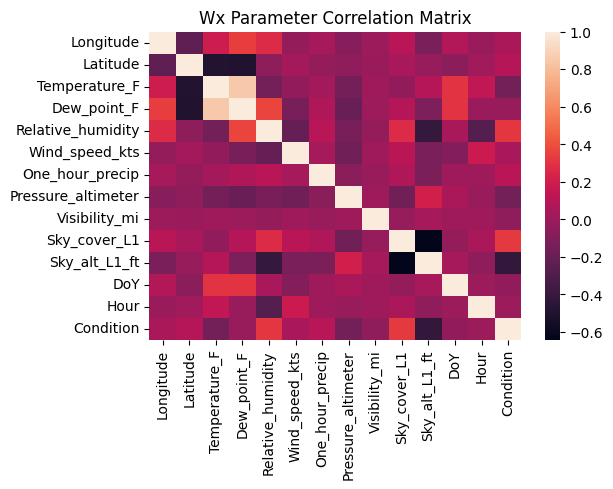

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert zipped list to `uniqlbl` for ML
uniqlbl,uniqval = map(list,zip(*cond_key))

# Calculate correlation between each parameter set
corr2 = df.corr(numeric_only=True)

# Plot correlation matrix
plt.figure(figsize = (6,4))
sns.heatmap(corr2, annot=False)
plt.title("Wx Parameter Correlation Matrix")
plt.show()

# Split and scale train / test data

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import utils

# Define parameter to predict
pred_pram = 'Condition'

# Splitting the data into independent and dependent variables
X = df.drop(columns=[pred_pram]).values
y = df[pred_pram].values
feature_list = list(df.drop(columns=[pred_pram]).columns)

# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert categorical columns into numerical columns for fitting
lab = preprocessing.LabelEncoder()
y_train = lab.fit_transform(y_train)
y_test = lab.fit_transform(y_test)

### Multi-model comparison: confusion matrices

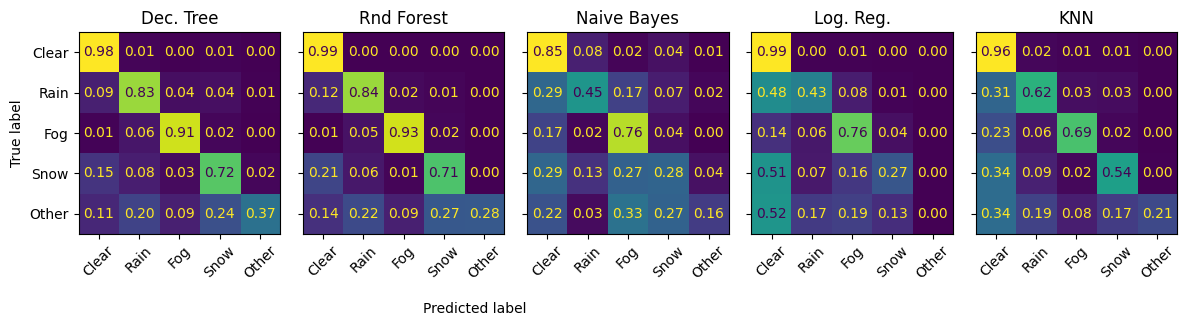

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# --------- PLOT TOP ROW OF CLASSIFIERS ---------
classifiers = {
    "Dec. Tree": DecisionTreeClassifier(),
    "Rnd Forest": RandomForestClassifier(n_estimators = 25, criterion = 'gini'),
    "Naive Bayes": GaussianNB(),
    "Log. Reg.": LogisticRegression(),
    "KNN": KNeighborsClassifier(3),
}

f, axes = plt.subplots(1, 5, figsize=(12,6), sharey='row')

log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
    
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=uniqlbl,
                                 )
    disp.plot(ax=axes[i], xticks_rotation=45,values_format='.2f')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')


f.text(0.4, 0.2, 'Predicted label', ha='center')
plt.rcParams["axes.grid"] = False
sns.set_color_codes("muted")
plt.grid(False)
plt.tight_layout()
plt.show()

### Classification report

In [11]:
from sklearn.metrics import classification_report

classifier = DecisionTreeClassifier()
y_pred = classifier.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, target_names=uniqlbl))

              precision    recall  f1-score   support

       Clear       0.98      0.98      0.98   1004228
        Rain       0.83      0.83      0.83    127621
         Fog       0.91      0.91      0.91     78773
        Snow       0.71      0.73      0.72     56047
       Other       0.34      0.37      0.35      3226

    accuracy                           0.95   1269895
   macro avg       0.75      0.76      0.76   1269895
weighted avg       0.95      0.95      0.95   1269895



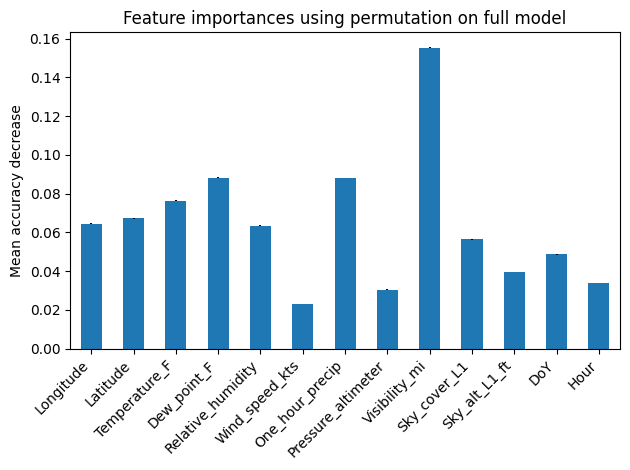

In [12]:
import time
from sklearn.inspection import permutation_importance

# Create a  regressor using all the feature variables
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Monitor feature importance for each permutation
result = permutation_importance(
    dt_model, X_test, y_test, n_repeats=10, n_jobs=4
)
forest_importances = pd.Series(result.importances_mean, index=feature_list)

# Plot feature importance using permutation on full model
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()